<a href="https://colab.research.google.com/github/TomazFilgueira/UFRN-ML-2025-1-Heart_Disease_Classfication/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

#Read csv file from Github


In [ ]:
url = "https://raw.githubusercontent.com/TomazFilgueira/UFRN-ML-2025-1-Heart_Disease_Classfication/main/data/cleaned_merged_heart_dataset.csv" # Correct URL to raw file content

try:
  df = pd.read_csv(url)
  print("Successfully read CSV from GitHub")
  # Now you can work with the DataFrame 'df'
  print(df.head()) # Example: Display the first few rows

except Exception as e:
  print(f"An error occurred: {e}")

Successfully read CSV from GitHub
   age  sex  cp  trestbps  chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3       145   233    1        0       150      0      2.3   
1   37    1   2       130   250    0        1       187      0      3.5   
2   41    0   1       130   204    0        0       172      0      1.4   
3   56    1   1       120   236    0        1       178      0      0.8   
4   57    0   0       120   354    0        1       163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1  


#EDA

##Stastical Summary

In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,54.354343,0.688559,1.279131,131.549258,246.855403,0.148305,0.597458,149.424258,0.331568,1.053761,1.421610,0.731462,2.662606,0.517479
std,9.081505,0.463205,1.280877,17.556985,51.609329,0.355496,0.638820,23.006153,0.470901,1.161344,0.619588,1.015735,1.249924,0.499827
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.750000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,276.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000,7.000000,1.000000


From stastical analysis above and comparing with maximum values described in the reference dataset we can see that there are some categorical columns with max. values higher than expected.

Those columns are:

`cp:` Chest pain type. Values: 0 = Typical angina, 1 = Atypical angina, 2 = Non-anginal pain, 3 = Asymptomatic. - **df Max Value = 04**

`slope:` Slope of the peak exercise ST segment. Values: 0 = Upsloping, 1 = Flat, 2 = Downsloping. . **DF max values = 03**

`ca:` Number of major vessels (0-3) colored by fluoroscopy. Values: 0, 1, 2, 3. **DF max. value = 04**

`thal:` Thalassemia types. Values: 1 = Normal, 2 = Fixed defect, 3 = Reversible defect. **DF Max. values = 07**

Next we will map the correct values for each column in order to avoid incorrect values.




#Map Categorical Columns

In order to better visualization, we will map categorical columns into new labels. Later on, we will create dummies variables

In [ ]:
df["sex"] = df["sex"].map({1: "Male", 0: "Female"})
df["cp"] = df["cp"].map({0: "Typical angina", 1: "Atypical angina", 2: "Non-anginal pain", 3: "Asymptomatic"})
df["restecg"] = df["restecg"].map({0: "Normal", 1: "ST-T wave abnormality", 2: "Left ventricular hypertrophy"})
df["exang"] = df["exang"].map({1: "Yes", 0: "No"})
df["slope"] = df["slope"].map({0: "Upsloping", 1: "Flat", 2: "Downsloping"})
df["thal"] = df["thal"].map({1: "Normal", 2: "Fixed defect", 3: "Reversible defect"})
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,Male,Asymptomatic,145,233,1,Normal,150,No,2.3,Upsloping,0,Normal,1
1,37,Male,Non-anginal pain,130,250,0,ST-T wave abnormality,187,No,3.5,Upsloping,0,Fixed defect,1
2,41,Female,Atypical angina,130,204,0,Normal,172,No,1.4,Downsloping,0,Fixed defect,1
3,56,Male,Atypical angina,120,236,0,ST-T wave abnormality,178,No,0.8,Downsloping,0,Fixed defect,1
4,57,Female,Typical angina,120,354,0,ST-T wave abnormality,163,Yes,0.6,Downsloping,0,Fixed defect,1


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   sex       1888 non-null   object 
 2   cp        1758 non-null   object 
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   object 
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   object 
 9   oldpeak   1888 non-null   float64
 10  slope     1870 non-null   object 
 11  ca        1888 non-null   int64  
 12  thal      1758 non-null   object 
 13  target    1888 non-null   int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 206.6+ KB
None


After mapping those columns it has been identified that the dataset was left with NAN obersvations.

Let's remove them.

##Dealing with Missing Values

Our analysis shows that there are not missing values. Meaning that all rows are complete filled.

In [ ]:
# Drop rows with any null values
df_dropna = df.dropna()
print(df_dropna.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1702 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1702 non-null   int64  
 1   sex       1702 non-null   object 
 2   cp        1702 non-null   object 
 3   trestbps  1702 non-null   int64  
 4   chol      1702 non-null   int64  
 5   fbs       1702 non-null   int64  
 6   restecg   1702 non-null   object 
 7   thalachh  1702 non-null   int64  
 8   exang     1702 non-null   object 
 9   oldpeak   1702 non-null   float64
 10  slope     1702 non-null   object 
 11  ca        1702 non-null   int64  
 12  thal      1702 non-null   object 
 13  target    1702 non-null   int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 199.5+ KB
None


From output above we can see that there are 1702 non-null rows and 12 numerical columns.

The last column represents the target one. It will be used to determined if the person if likely to have a heart disease or not

##Removing duplicated rows

After analyzing dupliced rows 1464 rows were removed from the original dataset. This number represents **77%%** of removal rows.

After the removal, the new dataset have 424 rows.

In [ ]:
# Removing duplicated rows
initial_rows = df.shape[0]
df_reduced = df_dropna.drop_duplicates().copy()
final_rows = df_reduced.shape[0]
removed_rows = initial_rows - final_rows
percentage_removed = (removed_rows / initial_rows) * 100

print(f"Removed {removed_rows} duplicated rows ({percentage_removed:.2f}% of the initial dataset)")
print(f"The dataset now has {final_rows} rows.")


Removed 1464 duplicated rows (77.54% of the initial dataset)
The dataset now has 424 rows.


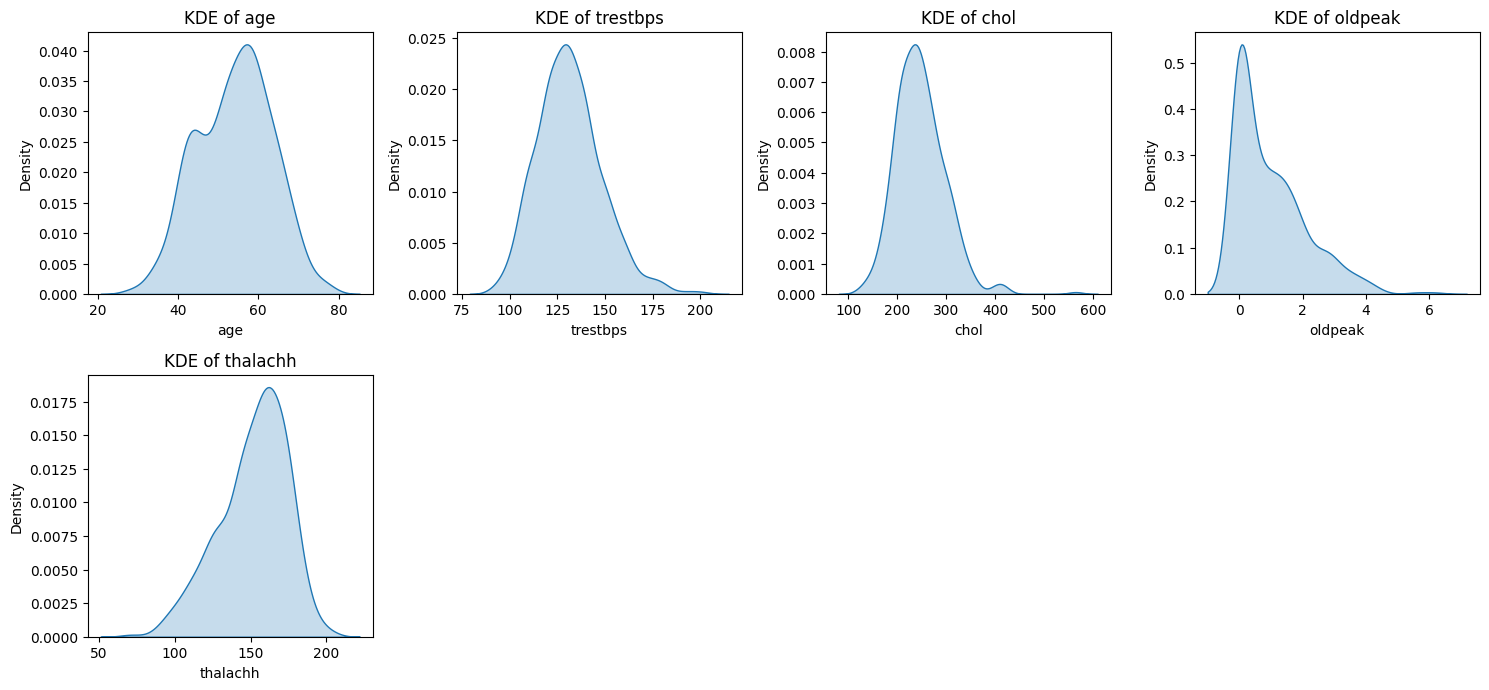

In [ ]:
# prompt: plot kde distribution

import seaborn as sns
import matplotlib.pyplot as plt

#Select numerical columns for KDE plots
categorical_cols = ['ca','fbs','sex','restecg','exang','slope','thal']
numerical_cols = ['age','trestbps','chol','oldpeak','thalachh']

# Plot KDE for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)  # Adjust the subplot grid as needed
    sns.kdeplot(df_reduced[col], fill=True)
    plt.title(f'KDE of {col}')
plt.tight_layout()
plt.show()


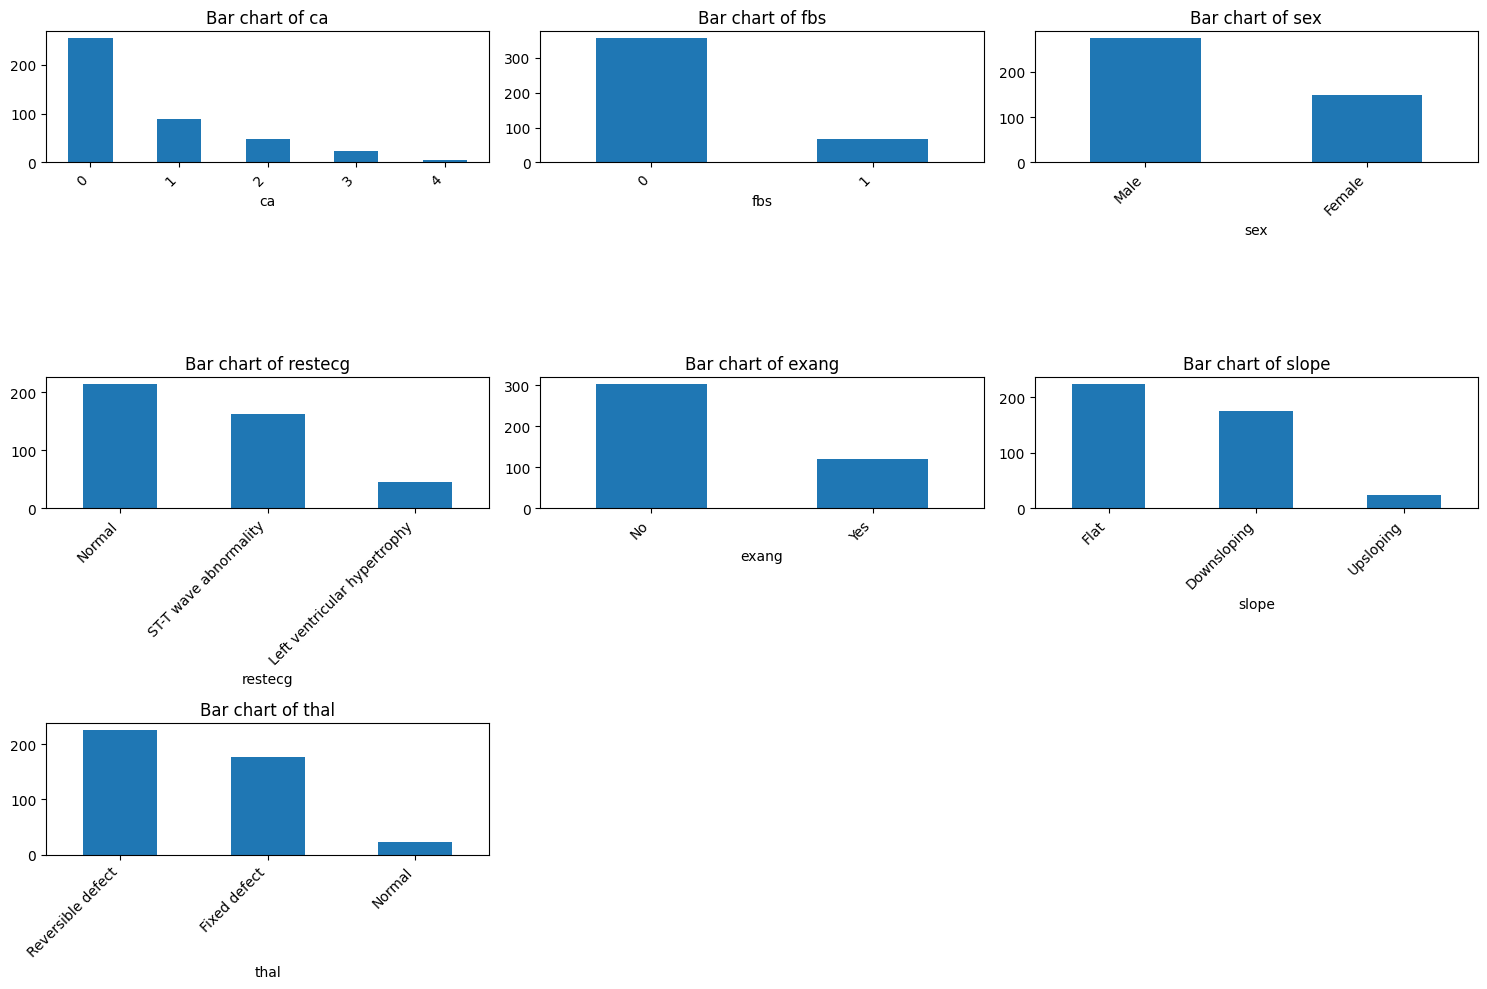

In [ ]:
# prompt: plot bar chart from categorical columns

# Plotting bar charts for categorical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)  # Adjust the subplot grid as needed
    df_reduced[col].value_counts().plot(kind='bar')
    plt.title(f'Bar chart of {col}')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


#Crosstab between Target Variable vs Age/Sex

Let's analyze how a heart disease can be distributed among people of different sex and ages.

For this comparison we will create a categorical feature from an aged interval named as: "`elderly`"


In [ ]:
# target vs [sex & age]?
df_reduced['elderly'] = df_reduced['age'].apply(lambda x: '>=60' if x >= 60 else '<60')
print(df_reduced)


      age     sex                cp  trestbps  chol  fbs  \
0      63    Male      Asymptomatic       145   233    1   
1      37    Male  Non-anginal pain       130   250    0   
2      41  Female   Atypical angina       130   204    0   
3      56    Male   Atypical angina       120   236    0   
4      57  Female    Typical angina       120   354    0   
...   ...     ...               ...       ...   ...  ...   
1873   45    Male    Typical angina       110   275    0   
1876   55    Male   Atypical angina       124   261    0   
1883   60    Male    Typical angina       140   207    0   
1886   54    Male   Atypical angina       154   232    0   
1887   53    Male    Typical angina       110   335    0   

                    restecg  thalachh exang  oldpeak        slope  ca  \
0                    Normal       150    No      2.3    Upsloping   0   
1     ST-T wave abnormality       187    No      3.5    Upsloping   0   
2                    Normal       172    No      1.4  Downsl

In [ ]:
#cross tab
pd.crosstab(df_reduced.target,[df_reduced.sex,df_reduced.elderly],margins=True)


sex     Female      Male       All
elderly    <60 >=60  <60 >=60     
target                            
0           44   31  119   50  244
1           49   25   88   18  180
All         93   56  207   68  424

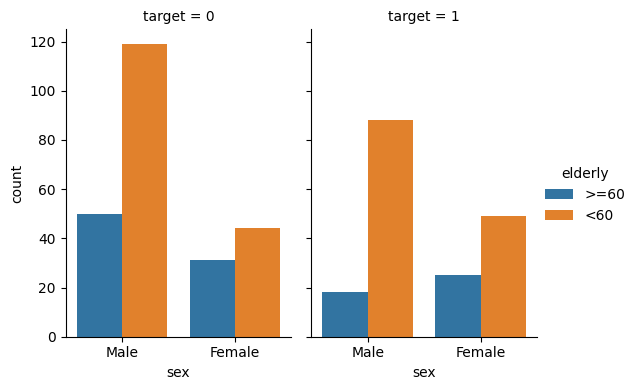

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot crosstab plot

%matplotlib inline

g = sns.catplot(x="sex",
            hue="elderly",
            col="target",
            data=df_reduced, kind="count",
            height=4, aspect=.7)
plt.show()

plt.savefig("Target_sex_age.png", dpi=100)

From the bargraph above surprisingly the dataset shows us the **male** people is more likely to have heart disease when they are **younger than 60 years old**!!

From women perspective, we can see that there are the same amount of individuals which had and had not a heart disease, comparing women younger thab 60 year old.

#Plot correlation matrix from numerical columns

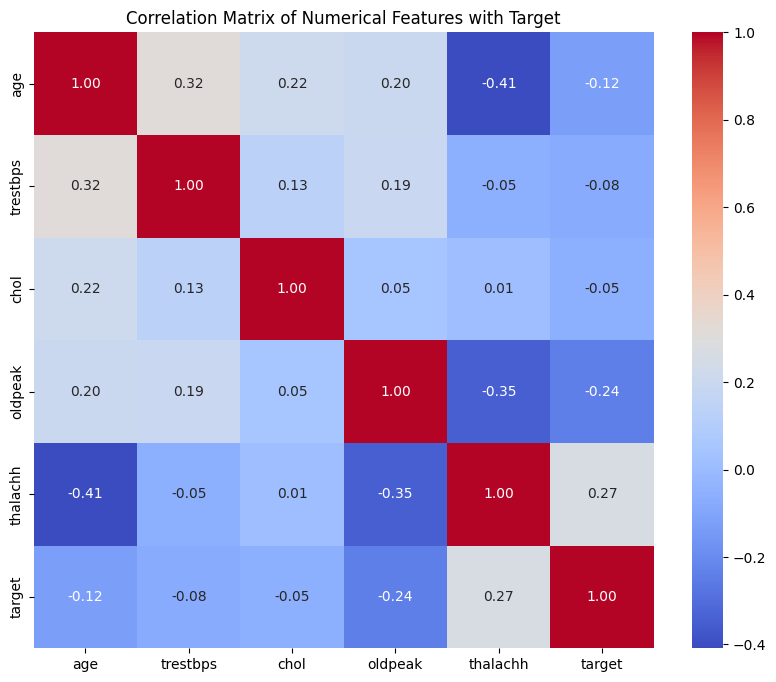

In [ ]:
# prompt: plot correlation matrix from numerical columns regarding to target column

# Assuming df_reduced is your DataFrame and 'target' is the name of your target column
numerical_cols = ['age', 'trestbps', 'chol', 'oldpeak', 'thalachh']  # Add other numerical columns if needed

# Calculate the correlation matrix
correlation_matrix = df_reduced[numerical_cols + ['target']].corr()

# Plotting the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features with Target')
plt.show()


In [ ]:
# Filter correlations above the threshold
high_correlations = correlation_matrix[abs(correlation_matrix)>0]['target']

# Print the high correlations
print("Features with high correlation with target:")
print(high_correlations)

Features with high correlation with target:
age        -0.122668
trestbps   -0.075342
chol       -0.051712
oldpeak    -0.242033
thalachh    0.265377
target      1.000000
Name: target, dtype: float64


Despite only two features (`thalachh` and `oldpeaks`) have highest correlation with target columns (0.26 and -0.24 respectively) we will use all those numerical columns in our classification problem.